In [4]:
import sys
from IPython.lib.deepreload import reload
from wordcloud import WordCloud

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud,ImageColorGenerator
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [6]:
dataTrain = pd.read_csv('drugsCom_raw/drugsComTrain_raw.tsv', sep='\t')
dataTest = pd.read_csv('drugsCom_raw/drugsComTest_raw.tsv', sep='\t')
dataset = pd.concat([dataTrain, dataTest])

In [8]:
dataset.tail()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,"October 8, 2016",11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,"November 15, 2010",7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,"November 28, 2011",20
53765,113712,Arthrotec,Sciatica,"""It works!!!""",9.0,"September 13, 2009",46


In [9]:
# we should not drop it
dataset['drugName'].nunique()

3671

In [6]:
# checking for null columns
dataset.isnull().any()

Unnamed: 0     False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

In [7]:
len(dataset)

215063

In [10]:
# drop it or nah?
# dataset = dataset.dropna()
dataTrain = dataTrain.fillna(".")
len(dataset) # length after dropping

215063

In [12]:
dataset.columns

Index(['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')

In [13]:
# Contact features and drop the rest on train

#different dataset
# dataTrain['text'] = dataTrain['condition']+' '+ dataTrain['effectiveness'] + ' '+ dataTrain['sideEffects'] + ' '+ dataTrain['benefitsReview'] + ' '+ dataTrain['sideEffectsReview'] + ' '+dataTrain['commentsReview']
dataTrain['text'] = dataTrain['condition']+' '+ dataTrain['drugName'] + ' '+ dataTrain['review']
# dataTrain['text'] =dataTrain['effectiveness']+' '+dataTrain['benefitsReview']
dataTrain.head(1)
        

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,text
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,"Left Ventricular Dysfunction Valsartan ""It has..."


In [14]:
# Old dataset
# features_to_drop = ['Unnamed: 0', 'urlDrugName', 'condition', 'effectiveness', 'sideEffects', 'benefitsReview', 'sideEffectsReview', 'commentsReview' ]
features_to_drop = ['Unnamed: 0', 'drugName', 'date', 'review', 'condition' ]
dataTrain = dataTrain.drop(features_to_drop, axis=1)
dataTrain.head(1)

,rating,usefulCount,text
0,9.0,27,"Left Ventricular Dysfunction Valsartan ""It has..."


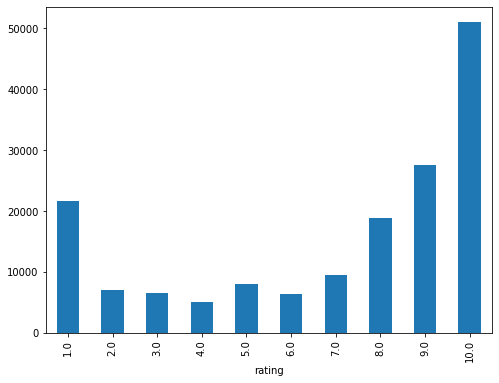

In [15]:
#number of reviews and ratings

fig = plt.figure(figsize=(8,6))
dataTrain.groupby('rating').text.count().plot.bar(ylim=0)

<Figure size 576x432 with 0 Axes>

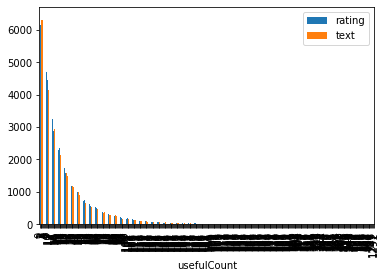

In [14]:
#number of reviews and ratings

fig = plt.figure(figsize=(8,6))
dataTrain.groupby('usefulCount').count().plot.bar(ylim=0)

In [15]:
# sum(dataTrain['rating'] > 5)

In [50]:
#dividng up rating for Sen analysis and create 3 triers mid low and hugh effectiveness
ratings = [
    (dataTrain['rating']<=5) & (dataTrain['rating']>1), (dataTrain['rating']<=10) & (dataTrain['rating']>5)
]
sentiment_level = ['low', 'high']
dataTrain['rt'] = np.select(ratings, sentiment_level, default='black') # rt = rating tier

#for test too
ratings = [
    (dataTest['rating']<=5) & (dataTest['rating']>1), (dataTest['rating']<=10) & (dataTest['rating']>5)
]
sentiment_level = ['low', 'high']
dataTest['rt'] = np.select(ratings, sentiment_level, default='black')



In [51]:
dataTrain.head(10)

,rating,usefulCount,text,rt
0,9.0,27,"Left Ventricular Dysfunction Valsartan ""It has...",high
1,8.0,192,"ADHD Guanfacine ""My son is halfway through his...",high
2,5.0,17,"Birth Control Lybrel ""I used to take another o...",low
3,8.0,10,"Birth Control Ortho Evra ""This is my first tim...",high
4,9.0,37,"Opiate Dependence Buprenorphine / naloxone ""Su...",high
5,2.0,43,"Benign Prostatic Hyperplasia Cialis ""2nd day o...",low
6,1.0,5,"Emergency Contraception Levonorgestrel ""He pul...",black
7,10.0,32,"Bipolar Disorde Aripiprazole ""Abilify changed ...",high
8,1.0,11,"Epilepsy Keppra "" I Ve had nothing but proble...",black
9,8.0,1,Birth Control Ethinyl estradiol / levonorgestr...,high


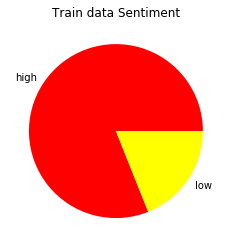

In [52]:
sent=dataTrain['rt']
counter = Counter(sent)
high = counter['high']
low = counter['low']
# medium = counter['medium']
labels = 'high', 'low'
sizes = [high, low]
colors = ['red', 'Yellow']
plt.pie(sizes, labels = labels, colors = colors)
plt.title("Train data Sentiment")
plt.show()


In [53]:
print(low, high)

26469 113209


In [54]:
low + high

139678

# There are more posive comments than others. Sherlock :-)

In [57]:
#Build frequency list 
txt = dataTrain.text.str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_freq = nltk.FreqDist(words)
# len(txt)
# len(words)

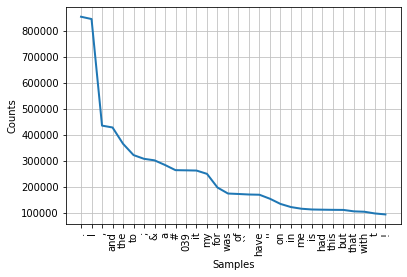

In [24]:
# view 30 most frequent words
word_freq.plot(30,cumulative=False)
plt.show()

In [25]:
word_freq.most_common(30)

[('.', 852939),
 ('I', 844128),
 (',', 434326),
 ('and', 427226),
 ('the', 364558),
 ('to', 321084),
 (';', 306652),
 ('&', 300845),
 ('a', 282981),
 ('#', 263106),
 ('039', 262415),
 ('it', 261576),
 ('my', 248859),
 ('for', 196358),
 ('was', 173229),
 ('of', 171471),
 ('``', 169489),
 ('have', 168575),
 ("''", 153108),
 ('on', 133273),
 ('in', 121153),
 ('me', 114771),
 ('is', 111871),
 ('had', 111107),
 ('this', 110524),
 ('but', 110201),
 ('that', 104681),
 ('with', 103188),
 ('t', 96600),
 ('!', 92916)]

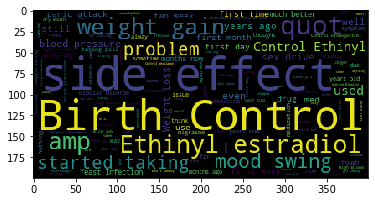

In [26]:
rslt = pd.DataFrame(word_freq.most_common(30), columns=['Word', 'Frequency'])
word_cloud = WordCloud().generate(txt)
plt.imshow(word_cloud)


In [58]:
#reomve unrelated english stop words
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
remove_stop_words = nltk.corpus.stopwords.words('english')

stop_words = rslt['Word'].values.tolist()


In [59]:
for w in remove_stop_words:
    if w not in stop_words:
        stop_words.append(w)

In [60]:
dataTrain.tail(2)

,rating,usefulCount,text,rt
161295,10.0,79,"Underactive Thyroid Thyroid desiccated ""I&#039...",high
161296,9.0,116,"Constipation, Chronic Lubiprostone ""I&#039;ve ...",high


In [1]:
5

5

In [61]:
#Build vectorizer on count vectors
cv = CountVectorizer(lowercase=True,stop_words=stop_words,tokenizer = token.tokenize)
#cv transform for commentsReview
text_counts= cv.fit_transform(dataTrain['text'])



In [62]:
# #Build vectorizer on Word Level TF IDF Vectors
tf=TfidfVectorizer()
text_tf= tf.fit_transform(dataTrain['text'])

In [46]:
text_counts.shape
dataTrain['rt']
# type(text_counts)

0           high
1           high
2         medium
3           high
4           high
           ...  
161292      high
161293       low
161294       low
161295      high
161296      high
Name: rt, Length: 161297, dtype: object

In [63]:
# for the CV
x_train, x_test, y_train, y_test = train_test_split(text_counts, dataTrain['rt'], test_size=0.4)

# for TF-IDF
# xtf_train, xtf_test, ytf_train, ytf_test = train_test_split(text_tf, dataTrain['rt'], test_size=0.4)

In [36]:
x_train.size

3847770

In [37]:
xtf_train.size

5902986

In [39]:
dataTrain.head(1)

,rating,usefulCount,text,rt
0,9.0,27,"Left Ventricular Dysfunction Valsartan ""It has...",high


# Naive Bayes Cv

In [64]:
nv = MultinomialNB()
nv.fit(x_train, y_train)
predict = nv.predict(x_train)

acc = nv.score(x_test, y_test)
acc

0.7027697267471598

# logistic Regression

In [68]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
acr = lr.score(x_test, y_test)
acr


/home/seedy/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7807932547001658

### Naive bayes score - 0.7027697267471598
### Logistic Regression score - 0.7807932547001658
